<a href="https://colab.research.google.com/github/KarthikeyanBaskaran/StockPrediction/blob/main/Capstone_Microsoft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
%%capture
!pip install yfinance

In [13]:
#Standard Practices

import pandas as pd
import datetime
import matplotlib.pyplot as plt

#YahooFinance
import yfinance as yf

#Statsmodels
from statsmodels.graphics.tsaplots import plot_acf

import statsmodels.api as sma
import statsmodels as sm
from statsmodels import tsa
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera
from scipy.stats import t, probplot


import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime, timedelta
import warnings


#metrics
from sklearn.metrics import r2_score, mean_squared_error

warnings.filterwarnings("ignore")


importing the dataset from yfinance

In [ ]:
# # Importing the dataset

# symbol = 'GOOG'

# df = yf.download(symbol, period="max", interval="1d")
# df.to_csv("GOOG.csv")

[*********************100%***********************]  1 of 1 completed


In [14]:
GOOG = pd.read_csv("https://raw.githubusercontent.com/KarthikeyanBaskaran/StockPrediction/refs/heads/main/GOOG.csv")
GOOG = GOOG[2:]
GOOG = GOOG.reset_index()
GOOG = GOOG.drop(columns=["index"])
GOOG = GOOG.rename(columns={"Price":"Date"})
columns_to_convert = ["Close", "High", "Low", "Open"]
GOOG[columns_to_convert] = GOOG[columns_to_convert].astype(float)
GOOG['Date'] = pd.to_datetime(GOOG['Date'])
GOOG['Volume'] = GOOG['Volume'].astype(int)
GOOG.head()

,Date,Close,High,Low,Open,Volume
0,2004-08-19,2.487352,2.579567,2.378775,2.478923,897427216
1,2004-08-20,2.684922,2.704009,2.491318,2.503960,458857488
2,2004-08-23,2.711942,2.813082,2.703266,2.745407,366857939
3,2004-08-24,2.599647,2.766478,2.567421,2.757554,306396159
4,2004-08-25,2.627658,2.677237,2.575105,2.601877,184645512


In [26]:
GOOG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5186 entries, 0 to 5185
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    5186 non-null   datetime64[ns]
 1   Close   5186 non-null   float64       
 2   High    5186 non-null   float64       
 3   Low     5186 non-null   float64       
 4   Open    5186 non-null   float64       
 5   Volume  5186 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 243.2 KB


In [34]:
# df = GOOG[(GOOG['Date'] >= datetime(2020, 1, 1)) & (GOOG['Date'] <= datetime(2025, 1, 31))].reset_index(drop=True)
df = GOOG[GOOG['Date'] >= datetime(2020, 1, 1)].reset_index(drop=True)


prices = df[['Close','Date']]
prices = prices[prices['Date']<= datetime(2025, 1, 31)]
prices = prices.set_index('Date')

actual = df[df['Date']> datetime(2025, 1, 31)].reset_index(drop=True)


### EDA

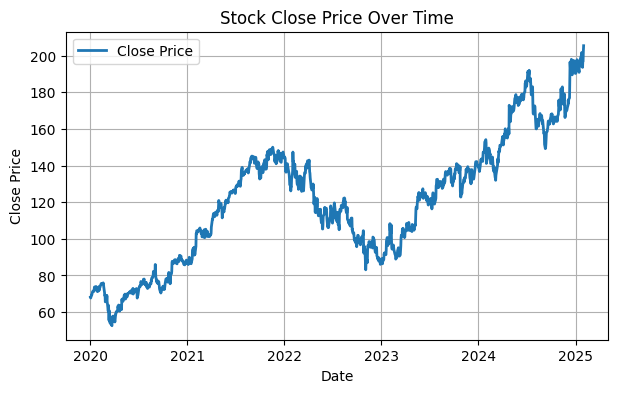

In [51]:
# Plot the Close price
plt.figure(figsize=(7, 4))
plt.plot(prices, linewidth=2, label="Close Price")

# Chart formatting
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Stock Close Price Over Time")
plt.legend()
plt.grid()

# Show the plot
plt.show()

### ARIMA

####Hypothesis testing:
null hypothesis: The stock is stationary

In [52]:
#Order of integration: Augmented Dickey-Fuller Test
adf = adfuller(x=prices['Close'], autolag='BIC')
print("The adf statistics is", format(adf[0], ".2f"))
print("The p value is",format(adf[1], ".2f"))

The adf statistics is -0.45
The p value is 0.90


Since p-value is more than 0.05 null hypothesis is rejected and the values are not stationary

#### ACF - Auto Correlation Function


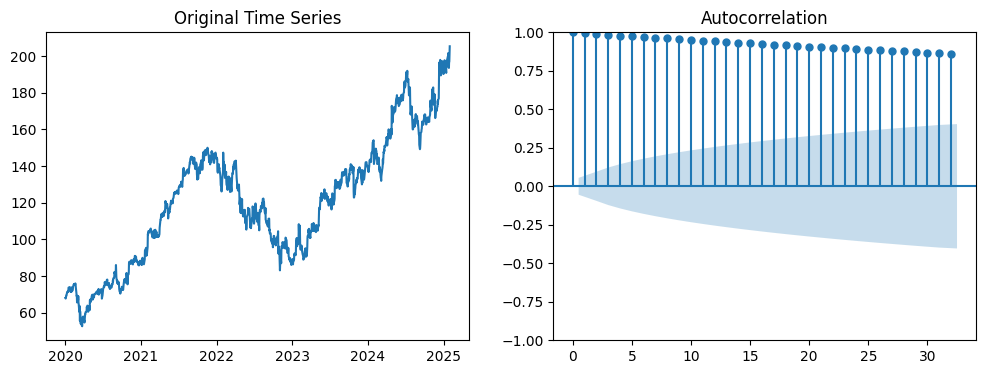

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(prices['Close'])
ax1.set_title('Original Time Series')
plot_acf(prices['Close'],ax=ax2);

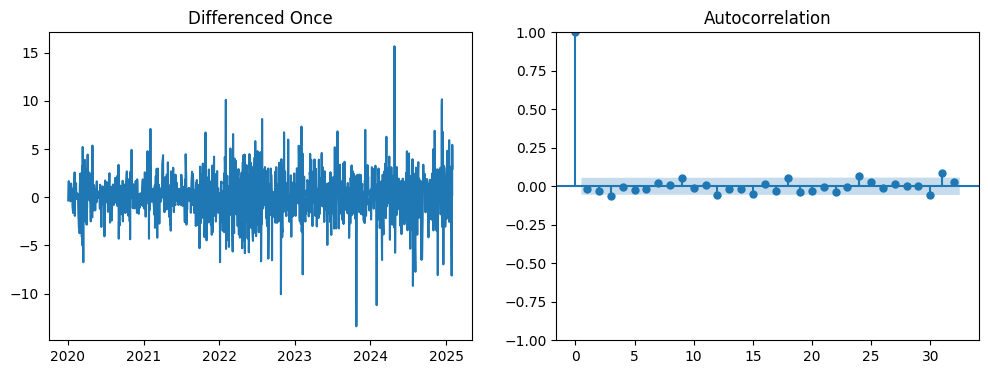

In [54]:
diff = prices.Close.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(diff)
ax1.set_title('Differenced Once')
plot_acf(diff,ax=ax2);

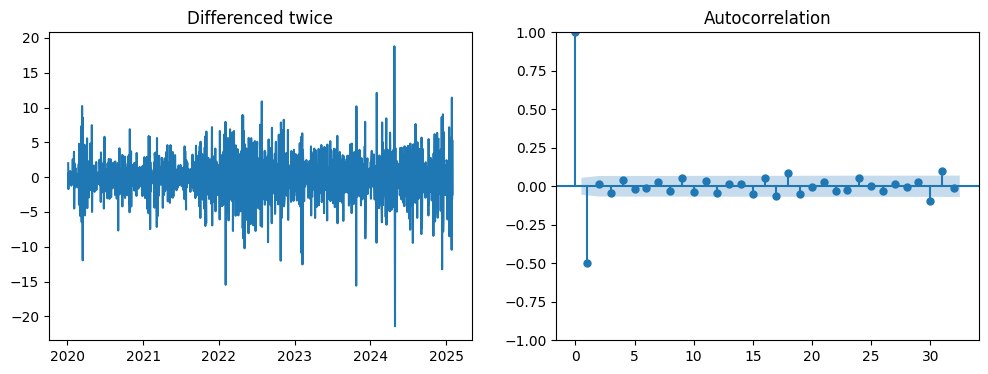

In [55]:
diff = prices.Close.diff().diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(diff)
ax1.set_title('Differenced twice')
plot_acf(diff,ax=ax2);

No bigger difference when differencing twice so selecting "order of differencing" as once and q = 8

p

In [14]:
from statsmodels.graphics.tsaplots import plot_pacf

(0.0, 1.0)

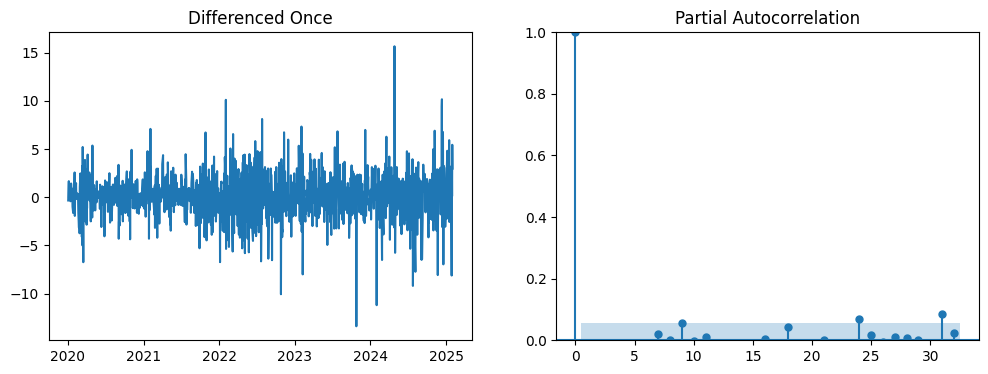

In [56]:
#p

diff = prices.Close.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(diff)
ax1.set_title('Differenced Once')
plot_pacf(diff,ax=ax2);
ax2.set_ylim(0,1)

We observe PACF lag 31 based on the plot

In [38]:
# Compute returns
returns = prices.pct_change().dropna()

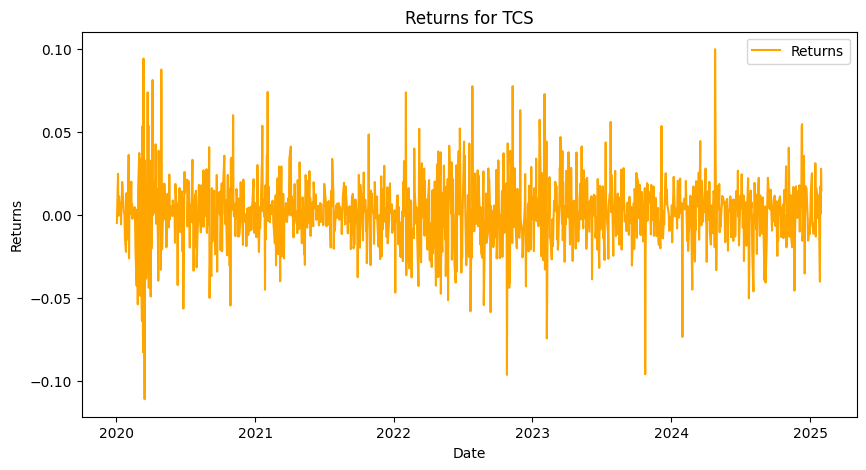

In [39]:
# Plot returns
plt.figure(figsize=(10, 5))
plt.plot(returns.index, returns, label='Returns', color='orange')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Returns for TCS')
plt.legend()
plt.show()


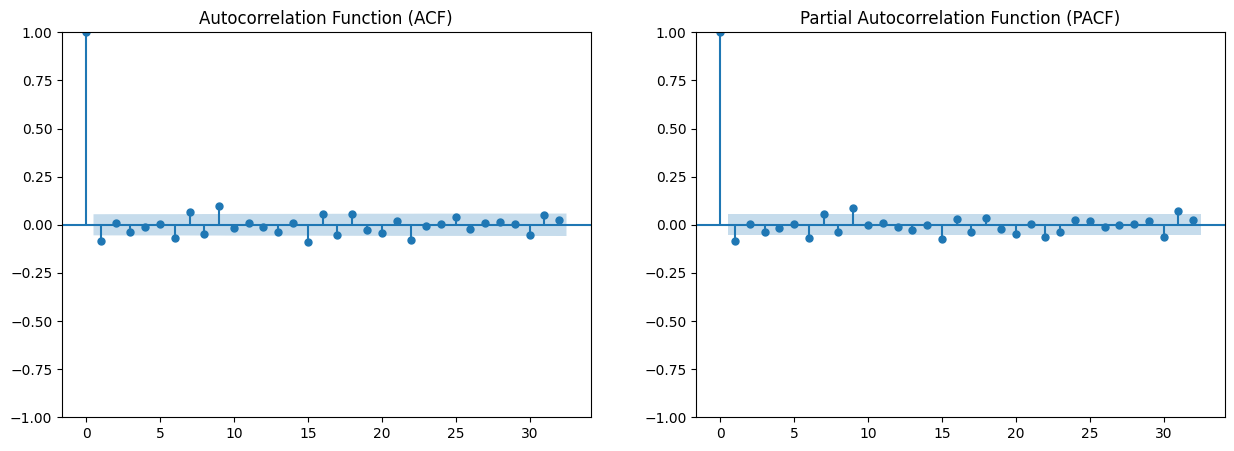

In [40]:

# ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(returns, ax=axes[0])
plot_pacf(returns, method='ywm', ax=axes[1])
axes[0].set_title("Autocorrelation Function (ACF)")
axes[1].set_title("Partial Autocorrelation Function (PACF)")
plt.show()

In [210]:
# Build ARIMA model (randomly chosen order, tuning required for better results)
model = ARIMA(prices, order=(11,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5147
Model:                ARIMA(11, 1, 1)   Log Likelihood               -8340.247
Date:                Thu, 03 Apr 2025   AIC                          16706.493
Time:                        07:54:28   BIC                          16791.591
Sample:                             0   HQIC                         16736.275
                               - 5147                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0074      4.444     -0.002      0.999      -8.717       8.703
ar.L2         -0.0326      0.074     -0.438      0.662      -0.179       0.113
ar.L3         -0.0552      0.145     -0.382      0.7

In [211]:
forecast = model_fit.get_forecast(steps=len(actual), alpha=0.05)
predicted_prices = forecast.predicted_mean
predicted_prices.reset_index().drop(columns=["index"])
predicted_dates = pd.date_range(start=prices.index[-1] + pd.Timedelta(days=1), periods=len(actual), freq='B')

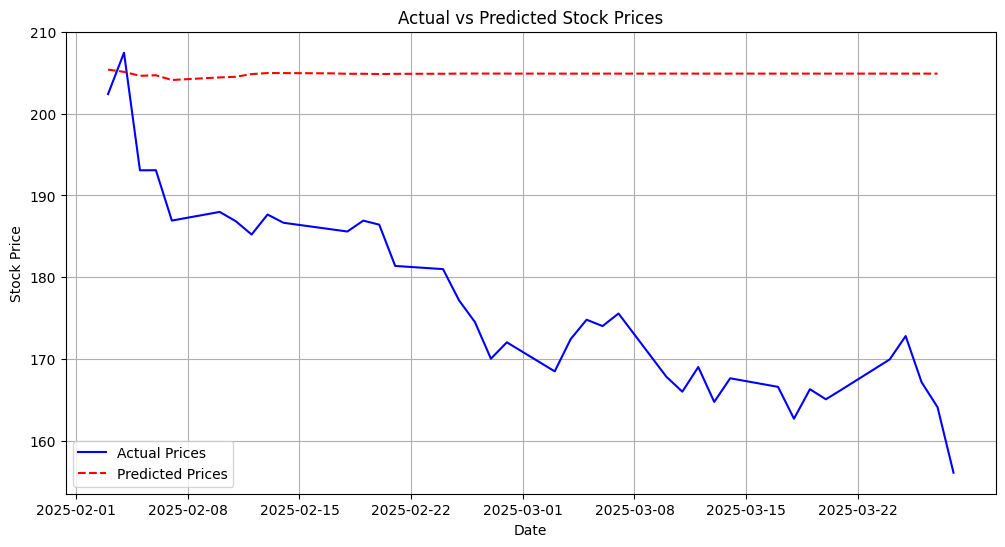

In [212]:
plt.figure(figsize=(12, 6))
plt.plot(actual['Date'], actual['Close'], label="Actual Prices", color='blue')

# Plot predicted stock prices
plt.plot(predicted_dates, predicted_prices, label="Predicted Prices", color='red', linestyle='dashed')

# Formatting
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices")
plt.legend()
plt.grid()

# Show plot
plt.show()

In [102]:
len(actual['Close']),len(predicted_prices)

(39, 39)

# Calculating metrics

In [213]:
r2_score(actual['Close'], predicted_prices)

-6.0584950649884135

In [137]:
print(f"AIC: {model_fit.aic}")
print(f"BIC: {model_fit.bic}")

AIC: 5815.486234209591
BIC: 6021.576988450893


In [214]:

rmse = np.sqrt(mean_squared_error(actual['Close'], predicted_prices))
print(f"RMSE: {rmse:.4f}")

RMSE: 30.4701


# Auto Arima

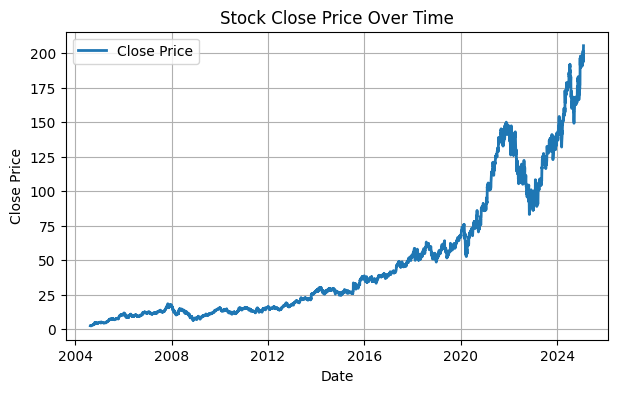

The adf statistics is 1.78
The p value is 1.00


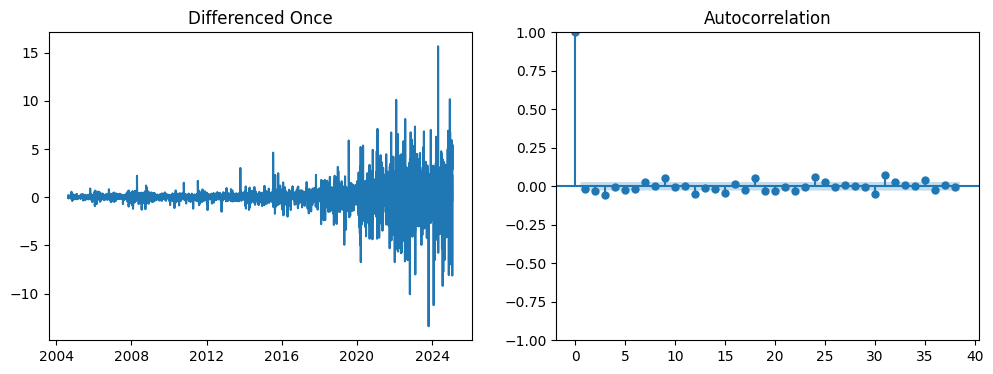

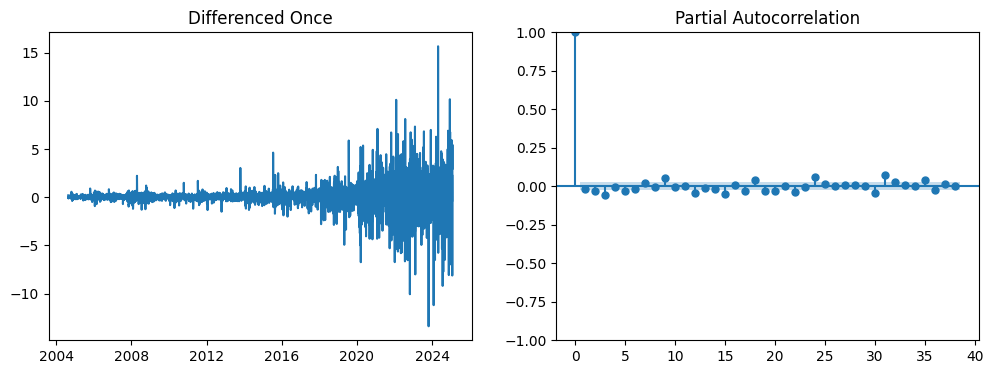

KeyboardInterrupt: 

In [60]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import warnings
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

warnings.filterwarnings("ignore")

# Importing the dataset from yfinance
GOOG = pd.read_csv("https://raw.githubusercontent.com/KarthikeyanBaskaran/StockPrediction/refs/heads/main/GOOG.csv")
GOOG = GOOG[2:]
GOOG = GOOG.reset_index()
GOOG = GOOG.drop(columns=["index"])
GOOG = GOOG.rename(columns={"Price":"Date"})
columns_to_convert = ["Close", "High", "Low", "Open"]
GOOG[columns_to_convert] = GOOG[columns_to_convert].astype(float)
GOOG['Date'] = pd.to_datetime(GOOG['Date'])
GOOG['Volume'] = GOOG['Volume'].astype(int)

# df = GOOG[GOOG['Date'] >= datetime.datetime(2020, 1, 1)].reset_index(drop=True)
df = GOOG
prices = df[['Close','Date']]
prices = prices[prices['Date']<= datetime.datetime(2025, 1, 31)]
prices = prices.set_index('Date')

actual = df[df['Date']> datetime.datetime(2025, 1, 31)].reset_index(drop=True)

# EDA
plt.figure(figsize=(7, 4))
plt.plot(prices, linewidth=2, label="Close Price")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Stock Close Price Over Time")
plt.legend()
plt.grid()
plt.show()

# Order of integration: Augmented Dickey-Fuller Test
adf = adfuller(x=prices['Close'], autolag='BIC')
print("The adf statistics is", format(adf[0], ".2f"))
print("The p value is",format(adf[1], ".2f"))

# ACF and PACF plots
diff = prices.Close.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(diff)
ax1.set_title('Differenced Once')
plot_acf(diff,ax=ax2);
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(diff)
ax1.set_title('Differenced Once')
plot_pacf(diff,ax=ax2);
plt.show()

# Prepare data for StatsForecast
train_sf = prices.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
train_sf['unique_id'] = 'GOOG'

# Initialize and fit AutoARIMA using StatsForecast
sf = StatsForecast(
    models=[AutoARIMA(season_length=90)], # You can adjust season_length as needed
    freq='B', # Business days frequency
)
sf.fit(train_sf)

# Generate forecast
forecast_sf = sf.predict(h=len(actual))

# Extract predicted prices
predicted_prices_sf = forecast_sf['AutoARIMA'].values

# Create predicted dates
predicted_dates_sf = pd.date_range(start=prices.index[-1] + pd.Timedelta(days=1), periods=len(actual), freq='B')

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(actual['Date'], actual['Close'], label="Actual Prices", color='blue')
plt.plot(predicted_dates_sf, predicted_prices_sf, label="Predicted Prices (AutoARIMA)", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices (AutoARIMA)")
plt.legend()
plt.grid()
plt.show()

# Calculate metrics
r2_sf = r2_score(actual['Close'], predicted_prices_sf)
rmse_sf = np.sqrt(mean_squared_error(actual['Close'], predicted_prices_sf))

print(f"R2 Score (AutoARIMA): {r2_sf}")
print(f"RMSE (AutoARIMA): {rmse_sf:.4f}")

In [57]:
%%capture
!pip install statsforecast

In [58]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import warnings
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

In [59]:

# Initialize and fit AutoARIMA using StatsForecast
sf = StatsForecast(
    models=[AutoARIMA(season_length=90)], # You can adjust season_length as needed
    freq='B', # Business days frequency
)
sf.fit(train_sf)

# Generate forecast
forecast_sf = sf.predict(h=22)

# Extract predicted prices
predicted_prices_sf = forecast_sf['AutoARIMA'].values

# Create predicted dates
predicted_dates_sf = pd.date_range(start=prices.index[-1] + pd.Timedelta(days=1), periods=22, freq='B')

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(actual['Date'], actual['Close'], label="Actual Prices", color='blue')
plt.plot(predicted_dates_sf, predicted_prices_sf, label="Predicted Prices (AutoARIMA)", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices (AutoARIMA)")
plt.legend()
plt.grid()
plt.show()

# Calculate metrics
r2_sf = r2_score(actual['Close'][:22], predicted_prices_sf)
rmse_sf = np.sqrt(mean_squared_error(actual['Close'][:22], predicted_prices_sf))

print(f"R2 Score (AutoARIMA): {r2_sf}")
print(f"RMSE (AutoARIMA): {rmse_sf:.4f}")

NameError: name 'train_sf' is not defined

In [187]:
# Calculate metrics
r2_sf = r2_score(actual['Close'][:22], predicted_prices_sf)
rmse_sf = np.sqrt(mean_squared_error(actual['Close'][:22], predicted_prices_sf))

print(f"R2 Score (AutoARIMA): {r2_sf}")
print(f"RMSE (AutoARIMA): {rmse_sf:.4f}")

R2 Score (AutoARIMA): -4.979636682501852
RMSE (AutoARIMA): 23.7695


Arimax

In [196]:
# prompt: filter from index 2020-01-01

df = GOOG[GOOG['Date'] >= '2020-01-01'].reset_index(drop=True)


,Close
Date,
2004-08-19,2.487352
2004-08-20,2.684922
2004-08-23,2.711942
2004-08-24,2.599647
2004-08-25,2.627658
...,...
2025-01-27,193.549500
2025-01-28,196.845749
2025-01-29,196.955612


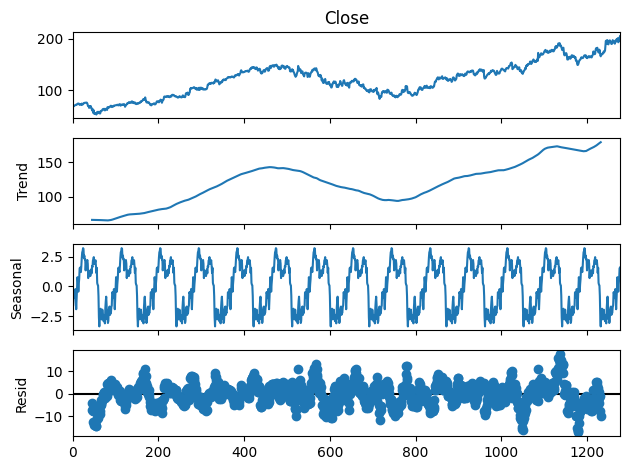

In [15]:
five = GOOG[(GOOG['Date'] >= '2020-01-01')&(GOOG['Date'] <= '2025-01-31')].reset_index(drop=True)

from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(five['Close'], model='additive', period = 90)
decompose.plot()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import acf, pacf

#identifying p
x_acf = acf(five['Close'], nlags = 40)
# x_pacf = pacf(five['Close'], nlags=40)
x_acf

array([1.        , 0.9942376 , 0.98871535, 0.98369043, 0.97895462,
       0.97444079, 0.9695966 , 0.96496592, 0.96020089, 0.95540664,
       0.9504759 , 0.94577966, 0.94094849, 0.93671125, 0.93248036,
       0.92827496, 0.92414563, 0.91981324, 0.91557905, 0.9113655 ,
       0.90745772, 0.90364515, 0.89981095, 0.89599493, 0.89202605,
       0.88775619, 0.88344783, 0.87941327, 0.87550044, 0.87156124,
       0.86720812, 0.86306238, 0.85889611, 0.85446057, 0.84982532,
       0.84567657, 0.84171829, 0.83789194, 0.83415694, 0.83019489,
       0.8264667 ])

In [207]:
len([1.        , 0.9942376 , 0.98871535, 0.98369043, 0.97895462,
       0.97444079, 0.9695966 , 0.96496592, 0.96020089, 0.95540664,
       0.9504759 ])

11

In [209]:
x_pacf = pacf(five['Close'])
x_pacf

array([ 1.00000000e+00,  9.95016174e-01,  2.09066908e-02,  4.75658742e-02,
        2.87896211e-02,  2.37973321e-02, -3.18166425e-02,  2.06084860e-02,
       -1.69951375e-02, -5.50605048e-03, -1.85534405e-02,  2.11750002e-02,
       -1.92076756e-02,  5.99794859e-02, -3.21860818e-04,  8.01047028e-03,
        6.33769817e-03, -1.66642682e-02,  2.51794798e-03,  2.04507984e-03,
        2.64073282e-02,  9.20342954e-03, -1.44617115e-03,  4.09490410e-03,
       -1.72737766e-02, -3.17580780e-02, -8.13122447e-03,  2.06374539e-02,
        9.51879373e-03, -5.33316582e-03, -3.99844853e-02,  1.79691870e-02])

In [ ]:
%%capture
!pip install pmdarima
!pip install "numpy<2"

In [16]:
five.head()

,Date,Close,High,Low,Open,Volume
0,2020-01-02,68.046196,68.084512,66.761282,66.761282,28132000
1,2020-01-03,67.712273,68.301485,66.960037,67.075290,23728000
2,2020-01-06,69.381874,69.495829,67.181792,67.181792,34646000
3,2020-01-07,69.338585,69.818809,69.191280,69.567504,30054000
4,2020-01-08,69.884987,70.246275,69.214161,69.275865,30560000


In [44]:
prices.head()

,Close
Date,
2020-01-02,68.046196
2020-01-03,67.712273
2020-01-06,69.381874
2020-01-07,69.338585
2020-01-08,69.884987


In [48]:
tilljan = GOOG[(GOOG['Date'] <= '2025-01-31')]
tilljan.tail()

,Date,Close,High,Low,Open,Volume
5142,2025-01-27,193.549500,198.443917,192.480710,193.969020,24970200
5143,2025-01-28,196.845749,197.005555,192.390818,194.428489,15939200
5144,2025-01-29,196.955612,198.234170,194.967886,197.145398,12287800
5145,2025-01-30,202.399414,203.006724,199.245003,199.532670,14571500
5146,2025-01-31,205.366043,206.844355,203.348337,203.483178,17087300


In [49]:

from pmdarima.arima import auto_arima

model = auto_arima(tilljan['Close'], seasonal=True, start_p=1, max_p=13, start_q=1, max_q=2, m=12, start_P= 0, trace=True, d = 1, D=1, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=11.76 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=20433.513, Time=0.23 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=18588.876, Time=0.78 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=4.86 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=20435.455, Time=0.33 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=18085.184, Time=2.09 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=13.21 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=4.53 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=18087.906, Time=1.72 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=18085.301, Time=2.84 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=inf, Time=15.59 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=18084.982, Time=2.39 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=18588.813, Time=1.28 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=12.88 sec
 ARIMA(0,1,1)(1,1,1)[12]             

In [50]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 5147
Model:             SARIMAX(0, 1, 2)x(2, 1, [], 12)   Log Likelihood               -9037.238
Date:                             Fri, 04 Apr 2025   AIC                          18084.476
Time:                                     02:47:39   BIC                          18117.195
Sample:                                          0   HQIC                         18095.928
                                            - 5147                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0337      0.006     -5.248      0.000      -0.046      -0.021
ma.L2         -0.0224      0.008     -2.891      0.004      -0.038      -0.007
ar.S.L12      -0.7241      0.006   -120.450      0.000      -0.736      -0.712
ar.S.L24      -0.3130      0.006    -51.797      0.000      -0.325      -0.301
sigma2         1.9765      0.014    144.525      0.000       1.950       2.003
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             46264.27
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):              78.81   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [51]:
%%capture
model.predict(n_periods=22)

In [52]:
forecast = model.predict(n_periods=22)
predicted_prices = forecast 
# predicted_prices.reset_index().drop(columns=["index"])
predicted_dates = pd.date_range(start=tilljan['Date'].iloc[-1]+ pd.Timedelta(days=1), periods=22, freq='B')

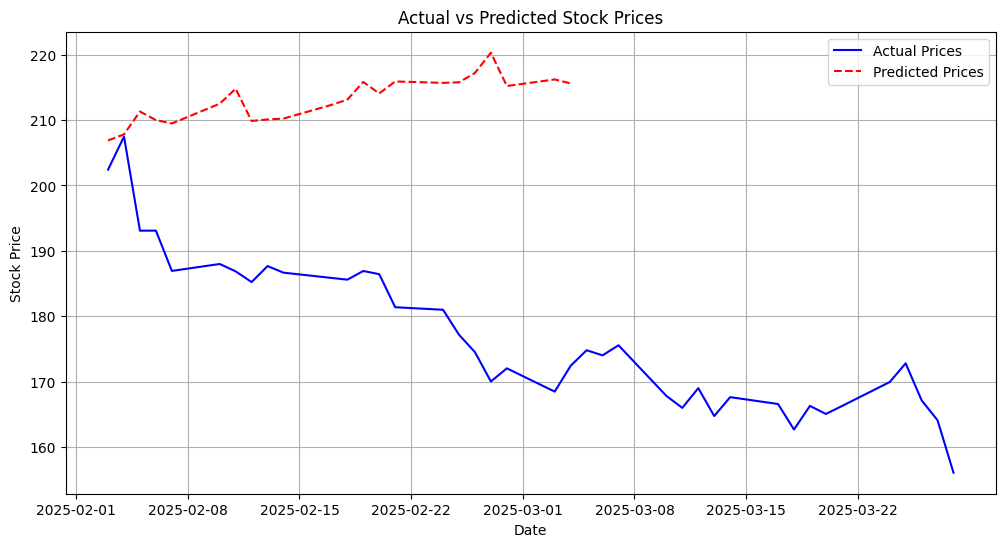

In [53]:
plt.figure(figsize=(12, 6))
plt.plot(actual['Date'], actual['Close'], label="Actual Prices", color='blue')

# Plot predicted stock prices
plt.plot(predicted_dates, predicted_prices, label="Predicted Prices", color='red', linestyle='dashed')

# Formatting
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices")
plt.legend()
plt.grid()

# Show plot
plt.show()

In [41]:

rmse = np.sqrt(mean_squared_error(actual['Close'].iloc[:22], predicted_prices))
print(f"RMSE: {rmse:.4f}")

RMSE: 31.8670


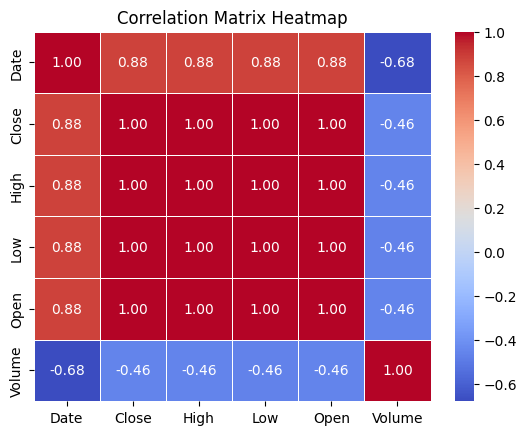

In [192]:
# prompt: create a corelation matrix for df
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [188]:
df

,Date,Close,High,Low,Open,Volume
0,2004-08-19,2.487352,2.579567,2.378775,2.478923,897427216
1,2004-08-20,2.684922,2.704009,2.491318,2.503960,458857488
2,2004-08-23,2.711942,2.813082,2.703266,2.745407,366857939
3,2004-08-24,2.599647,2.766478,2.567421,2.757554,306396159
4,2004-08-25,2.627658,2.677237,2.575105,2.601877,184645512
...,...,...,...,...,...,...
5181,2025-03-24,169.929993,170.500000,167.440002,169.264999,18742800
5182,2025-03-25,172.789993,172.910004,170.550003,171.179993,13841600
5183,2025-03-26,167.139999,171.940002,166.860992,171.300003,22554200
5184,2025-03-27,164.080002,167.440002,163.850006,166.710007,21571200
